In [1]:
import matplotlib.pyplot as plt
# Hack the cython magic so that it can set the correct C++ standard.
%load_ext Cython
import sys
from Cython.Build import IpythonMagic

orig_cython = IpythonMagic.CythonMagics.cython

def patched_cython(self, line, cell):
    # Add platform-correct C++ standard flag if not already present
    if "/std:c++" not in line and "-std=c++" not in line:
        if sys.platform.startswith("win"):
            line += " --cplus -c /std:c++20"
        else:
            line += " --cplus -c -std=c++20"
            
    return orig_cython(self, line, cell)

# Preserve the magic parser attribute so IPython still knows how to parse
patched_cython.parser = orig_cython.parser

# Patch it in
IpythonMagic.CythonMagics.cython = patched_cython

ip = get_ipython()
ip.register_magics(IpythonMagic.CythonMagics)

# Arbitrary Additional Arguments

## Additional Args = Array of Doubles
See discussion in "Advanced CySolver.md"

In [2]:
%%cython --force 
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np
np.import_array()

from libc.math cimport sin
from libcpp.utility cimport move
from libcpp.vector cimport vector

from CyRK cimport cysolve_ivp, WrapCySolverResult, DiffeqFuncType, MAX_STEP, CySolveOutput, PreEvalFunc, ODEMethod

cdef void pendulum_diffeq(double* dy_ptr, double t, double* y_ptr, char* args_ptr, PreEvalFunc pre_eval_func) noexcept nogil:
    # Arguments are passed in as char pointers.
    # These point to preallocated and instantiated memory in the CySolver class that is filled with user-provided data.

    # The user can then recast the generic char pointers back to original format of args_ptr. In this case, an array of doubles. 
    # Seg faults will occur if this function recasts to the incorrect type.
    cdef double* args_dbl_ptr = <double*>args_ptr
    cdef double l = args_dbl_ptr[0]
    cdef double m = args_dbl_ptr[1]
    cdef double g = args_dbl_ptr[2]

    cdef double coeff_1 = (-3. * g / (2. * l))
    cdef double coeff_2 = (3. / (m * l**2))

    # Unpack y
    cdef double y0, y1, torque
    y0 = y_ptr[0]
    y1 = y_ptr[1]

    # External torque
    torque = 0.1 * sin(t)

    dy_ptr[0] = y1
    dy_ptr[1] = coeff_1 * sin(y0) + coeff_2 * torque


# Now we define a function that builds our inputs and calls `cysolve_ivp` to solve the problem
def run():
    cdef DiffeqFuncType diffeq = pendulum_diffeq

    # Define time domain
    cdef double t_start = 0.0
    cdef double t_end = 10.0
    
    # Define initial conditions
    cdef vector[double] y0_vec = vector[double](2)
    y0_vec[0] = 0.01
    y0_vec[1] = 0.0
    
    # Define our arguments in a char vector
    # The size of the vector is the size of the underlying object(s) x number of them.
    cdef vector[char] args_vec = vector[char](sizeof(double) * 3)
    # To make it easier to populate the args_vec we recast it as a double pointer.
    cdef double* args_dbl_ptr = <double*>args_vec.data()
    args_dbl_ptr[0] = 1.0
    args_dbl_ptr[1] = 1.0
    args_dbl_ptr[2] = 9.81

    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_start,
        t_end,
        y0_vec,
        method = ODEMethod.RK45, # Integration method
        rtol = 1.0e-6,
        atol = 1.0e-8,
        args_vec = args_vec
        )

    # If we want to pass the solution back to python we need to wrap it in a CyRK `WrapCySolverResult` class.
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(move(result))

    return pysafe_result

result_reg = run()
print("\n\nIntegration success =", result_reg.success, "\n\tNumber of adaptive time steps required:", result_reg.size)
print("Integration message:", result_reg.message)

Content of stdout:
_cython_magic_c280d25c41ea6951d4b56700a4054cc32df09c8bca03bc24079a24b063c85dff.cpp
C:\Users\joepr\miniforge3\envs\cyrk313\Lib\site-packages\numpy\_core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_c280d25c41ea6951d4b56700a4054cc32df09c8bca03bc24079a24b063c85dff.cpp(25340): warning C4551: function call missing argument list
C:\Users\joepr\.ipython\cython\_cython_magic_c280d25c41ea6951d4b56700a4054cc32df09c8bca03bc24079a24b063c85dff.cpp(28608): warning C4551: function call missing argument list
C:\Users\joepr\.ipython\cython\_cython_magic_c280d25c41ea6951d4b56700a4054cc32df09c8bca03bc24079a24b063c85dff.cpp(28615): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_c280d25c41ea6951d4b56700a4054cc32df09c8bca03bc24079a24b063c85dff.

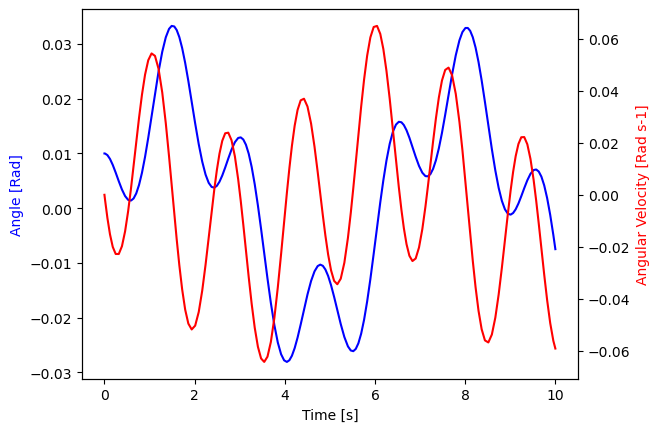

In [3]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(result_reg.t, result_reg.y[0], c='b')
ax2.plot(result_reg.t, result_reg.y[1], c='r')
ax.set_ylabel("Angle [Rad]", c='b')
ax.set_xlabel("Time [s]")
ax2.set_ylabel("Angular Velocity [Rad s-1]", c='r')
plt.show()

## Additional Args = Cython C-Struct
See discussion in "Advanced CySolver.md"

In [4]:
%%cython --force 
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np
np.import_array()

from libc.string cimport memcpy
from libc.math cimport sin
from libcpp cimport bool as cpp_bool
from libcpp.utility cimport move
from libcpp.vector cimport vector

from CyRK cimport cysolve_ivp, WrapCySolverResult, DiffeqFuncType,MAX_STEP, CySolveOutput, PreEvalFunc, ODEMethod

cdef struct PendulumArgs:
    # Structure that contains heterogeneous types
    cpp_bool use_drag
    double g
    double l
    double m

cdef void pendulum_diffeq(double* dy_ptr, double t, double* y_ptr, char* args_ptr, PreEvalFunc pre_eval_func) noexcept nogil:
    # Arg pointer still must be listed as a char pointer or it will not work with cysolve_ivp.
    # But now the user can recast that char pointer to the structure they wish.
    cdef PendulumArgs* pendulum_args_ptr = <PendulumArgs*>args_ptr
    # And easily access its members which can be many heterogeneous types.
    cdef double l = pendulum_args_ptr.l
    cdef double m = pendulum_args_ptr.m
    cdef double g = pendulum_args_ptr.g
    cdef double use_drag = pendulum_args_ptr.use_drag

    cdef double coeff_1 = (-3. * g / (2. * l))
    cdef double coeff_2 = (3. / (m * l**2))

    # Unpack y
    cdef double y0, y1, torque
    y0 = y_ptr[0]
    y1 = y_ptr[1]

    # External torque
    torque = 0.1 * sin(t)

    dy_ptr[0] = y1
    dy_ptr[1] = coeff_1 * sin(y0) + coeff_2 * torque

    if use_drag:
        dy_ptr[1] -= 1.5 * y1

# Now we define a function that builds our inputs and calls `cysolve_ivp` to solve the problem
def run():
    cdef DiffeqFuncType diffeq = pendulum_diffeq

    # Define time domain
    cdef double t_start = 0.0
    cdef double t_end = 10.0
    
    # Define initial conditions
    cdef vector[double] y0_vec = vector[double](2)
    y0_vec[0] = 0.01
    y0_vec[1] = 0.0
    
    # Define our arguments.
    # We now have a a structure that we need to allocate memory for.
    # For this example, let's do it on the stack. 
    cdef PendulumArgs pendulum_args = PendulumArgs(True, 9.81, 1.0, 1.0)
    # We need to pass in a char vector to cysolve_ivp, so let's create a vector of the correct size
    cdef vector[char] args_vec = vector[char](sizeof(PendulumArgs))
    # Then we need to copy over the contents to this vector.
    memcpy(args_vec.data(), &pendulum_args, sizeof(PendulumArgs))

    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_start,
        t_end,
        y0_vec,
        method = ODEMethod.RK45,
        rtol = 1.0e-6,
        atol = 1.0e-8,
        args_vec = args_vec
        )

    # If we want to pass the solution back to python we need to wrap it in a CyRK `WrapCySolverResult` class.
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(move(result))

    return pysafe_result

result_drag = run()
print("\n\nIntegration success =", result_drag.success, "\n\tNumber of adaptive time steps required:", result_drag.size)
print("Integration message:", result_drag.message)

Content of stdout:
_cython_magic_85717504bc52217d64b2a18ef77c6ae222ebbe6ad1efafdd8e7c24bf5514c181.cpp
C:\Users\joepr\miniforge3\envs\cyrk313\Lib\site-packages\numpy\_core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_85717504bc52217d64b2a18ef77c6ae222ebbe6ad1efafdd8e7c24bf5514c181.cpp(25400): warning C4551: function call missing argument list
C:\Users\joepr\.ipython\cython\_cython_magic_85717504bc52217d64b2a18ef77c6ae222ebbe6ad1efafdd8e7c24bf5514c181.cpp(28668): warning C4551: function call missing argument list
C:\Users\joepr\.ipython\cython\_cython_magic_85717504bc52217d64b2a18ef77c6ae222ebbe6ad1efafdd8e7c24bf5514c181.cpp(28675): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_85717504bc52217d64b2a18ef77c6ae222ebbe6ad1efafdd8e7c24bf5514c181.

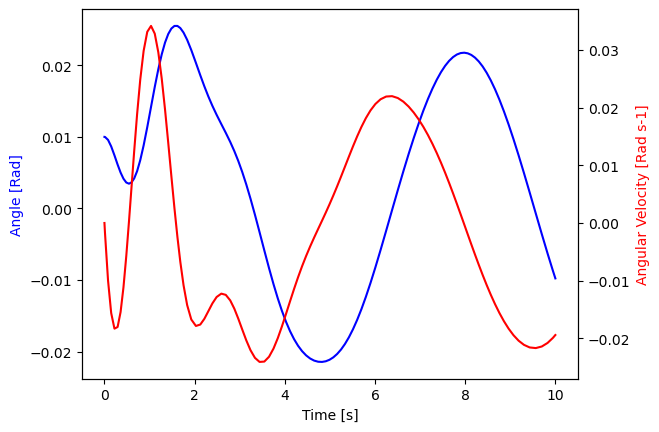

In [5]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(result_drag.t, result_drag.y[0], c='b')
ax2.plot(result_drag.t, result_drag.y[1], c='r')
ax.set_ylabel("Angle [Rad]", c='b')
ax.set_xlabel("Time [s]")
ax2.set_ylabel("Angular Velocity [Rad s-1]", c='r')
plt.show()

# Pre-Evaluation Functions
See discussion in "Advanced CySolver.md"

In [6]:
%%cython --force 
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np
np.import_array()

from libc.math cimport sin
from libcpp.utility cimport move
from libcpp.vector cimport vector

from CyRK cimport cysolve_ivp, WrapCySolverResult, DiffeqFuncType, MAX_STEP, CySolveOutput, PreEvalFunc, ODEMethod

cdef void pendulum_preeval_nodrag(char* output_ptr, double time, double* y_ptr, char* args_ptr) noexcept nogil:
    # Unpack args (in this example we do not need these but they follow the same rules as the Arbitrary Args section discussed above)
    cdef double* args_dbl_ptr = <double*>args_ptr

    # External torque
    cdef double torque = 0.1 * sin(time)

    # Convert output pointer to double pointer so we can store data
    cdef double* output_dbl_ptr = <double*>output_ptr
    output_dbl_ptr[0] = torque
    output_dbl_ptr[1] = 0.0  # No Drag

cdef void pendulum_preeval_withdrag(char* output_ptr, double time, double* y_ptr, char* args_ptr) noexcept nogil:
    # Unpack args (in this example we do not need these but they follow the same rules as the Arbitrary Args section discussed above)
    cdef double* args_dbl_ptr = <double*>args_ptr

    # External torque
    cdef double torque = 0.1 * sin(time)

    # Convert output pointer to double pointer so we can store data
    cdef double* output_dbl_ptr = <double*>output_ptr
    output_dbl_ptr[0] = torque
    output_dbl_ptr[1] = -1.5 * y_ptr[1]  # With Drag


cdef void pendulum_preeval_diffeq(double* dy_ptr, double t, double* y_ptr, char* args_ptr, PreEvalFunc pre_eval_func) noexcept nogil:

    # Build other parameters that do not depend on the pre-eval func
    cdef double* args_dbl_ptr = <double*>args_ptr
    cdef double l = args_dbl_ptr[0]
    cdef double m = args_dbl_ptr[1]
    cdef double g = args_dbl_ptr[2]

    cdef double coeff_1 = (-3. * g / (2. * l))
    cdef double coeff_2 = (3. / (m * l**2))

    # Make stack allocated storage for pre eval output
    cdef double[4] pre_eval_storage
    cdef double* pre_eval_storage_ptr = &pre_eval_storage[0]

    # Cast storage to char so we can call function
    cdef char* pre_eval_storage_char_ptr = <char*>pre_eval_storage_ptr

    # Call Pre-Eval Function
    # Note that even though CyRK calls this function a "pre-eval" function, it can be placed anywhere inside the diffeq function. 
    pre_eval_func(pre_eval_storage_char_ptr, t, y_ptr, args_ptr)

    cdef double y0 = y_ptr[0]
    cdef double y1 = y_ptr[1]

    # Use results of pre-eval function to update dy. Note that we are using the double* not the char* here.
    # Even though pre_eval_func was passed the char* it updated the memory that the double* pointed to so we can use it below.
    dy_ptr[0] = y1
    dy_ptr[1] = coeff_1 * sin(y0) + coeff_2 * pre_eval_storage_ptr[0] + pre_eval_storage_ptr[1]


# Now we define a function that builds our inputs and calls `cysolve_ivp` to solve the problem
def run():
    cdef DiffeqFuncType diffeq = pendulum_preeval_diffeq
    
    # Setup pointer to pre-eval function
    cdef PreEvalFunc pre_eval_func
    
    cdef bint use_drag = True
    if use_drag:
        pre_eval_func = pendulum_preeval_withdrag
    else:
        pre_eval_func = pendulum_preeval_nodrag
    
    # Define time domain
    cdef double t_start = 0.0
    cdef double t_end   = 10.0
    
    # Define initial conditions
    cdef vector[double] y0_vec = vector[double](2)
    y0_vec[0] = 0.01
    y0_vec[1] = 0.0

    # Define our arguments.
    cdef vector[char] args_vec = vector[char](sizeof(double) * 3)
    cdef double* args_dbl_ptr = <double*>args_vec.data()
    args_dbl_ptr[0] = 1.0
    args_dbl_ptr[1] = 1.0
    args_dbl_ptr[2] = 9.81

    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_start,
        t_end,
        y0_vec,
        method = ODEMethod.RK45, # Integration method
        rtol = 1.0e-6,
        atol = 1.0e-8,
        args_vec = args_vec,
        num_extra = 0,
        max_num_steps = 100_000_000,
        max_ram_MB = 2000,
        dense_output = False,
        t_eval_vec = vector[double](), # C++ / Cython require you to provide args in order even if they unused like t_eval_vec here.
        pre_eval_func = pre_eval_func
        )

    # If we want to pass the solution back to python we need to wrap it in a CyRK `WrapCySolverResult` class.
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(move(result))

    return pysafe_result

result_preeval = run()
print("\n\nIntegration success =", result_preeval.success, "\n\tNumber of adaptive time steps required:", result_preeval.size)
print("Integration message:", result_preeval.message)

Content of stdout:
_cython_magic_98c43fc563ccb04e027d94bd3b3a749656b9be144732d7e29c2d02a45be15b24.cpp
C:\Users\joepr\miniforge3\envs\cyrk313\Lib\site-packages\numpy\_core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_98c43fc563ccb04e027d94bd3b3a749656b9be144732d7e29c2d02a45be15b24.cpp(25576): warning C4551: function call missing argument list
C:\Users\joepr\.ipython\cython\_cython_magic_98c43fc563ccb04e027d94bd3b3a749656b9be144732d7e29c2d02a45be15b24.cpp(28844): warning C4551: function call missing argument list
C:\Users\joepr\.ipython\cython\_cython_magic_98c43fc563ccb04e027d94bd3b3a749656b9be144732d7e29c2d02a45be15b24.cpp(28851): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_98c43fc563ccb04e027d94bd3b3a749656b9be144732d7e29c2d02a45be15b24.

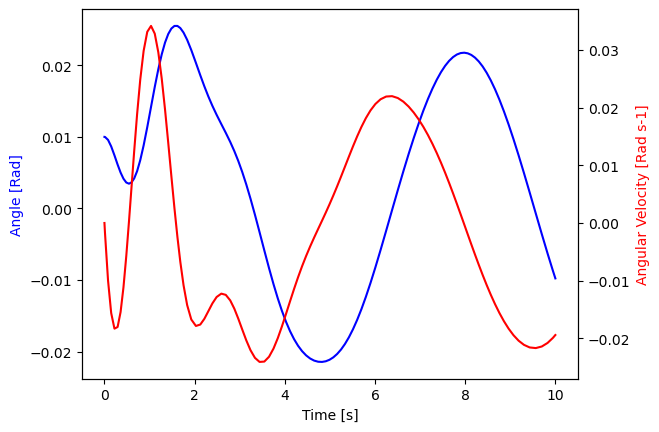

In [7]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(result_preeval.t, result_preeval.y[0], c='b')
ax2.plot(result_preeval.t, result_preeval.y[1], c='r')
ax.set_ylabel("Angle [Rad]", c='b')
ax.set_xlabel("Time [s]")
ax2.set_ylabel("Angular Velocity [Rad s-1]", c='r')
plt.show()

# PySolver and CySolver Solution Reuses
See discussion in "CySolver & PySolver Reuses.md"

## PySolver

Was Integration was successful? True
Integration completed without issue.
Size of solution:  360


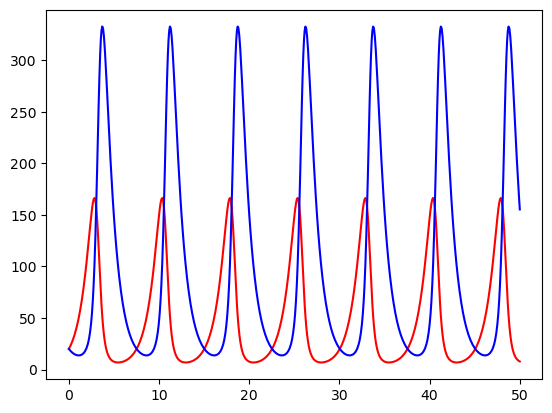

Was Integration was successful? True
Integration completed without issue.
Size of solution:  601


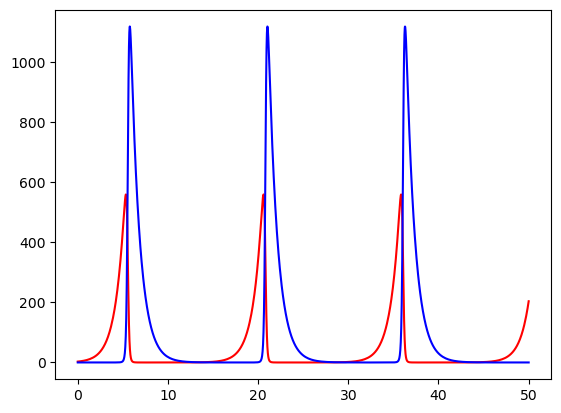

In [16]:
# Note if using this format, `dy` must be the first argument. Additionally, a special flag must be set to True when calling pysolve_ivp, see below.
def cy_diffeq(dy, t, y):
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]

# Since this is pure python we can njit it safely
from numba import njit
cy_diffeq = njit(cy_diffeq)
    
import numpy as np
from CyRK import pysolve_ivp

initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

result = \
    pysolve_ivp(cy_diffeq, time_span, initial_conds,
                method="RK45", rtol=rtol, atol=atol, pass_dy_as_arg=True)

# Use the result's memory allocation to re-call pysolve_ivp
result = \
    pysolve_ivp(cy_diffeq, time_span, initial_conds,
                method="RK45", rtol=rtol, atol=atol, pass_dy_as_arg=True,
                solution_reuse=result) # Set the reuse argument.

print("Was Integration was successful?", result.success)
print(result.message)
print("Size of solution: ", result.size)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')
plt.show()

# We can change parameters too
new_initial_conds = np.asarray((3., 0.1), dtype=np.float64, order='C')
result = \
    pysolve_ivp(cy_diffeq, time_span, new_initial_conds,
                method="RK45", rtol=rtol, atol=atol, pass_dy_as_arg=True,
                solution_reuse=result) # Set the reuse argument.

print("Was Integration was successful?", result.success)
print(result.message)
print("Size of solution: ", result.size)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')
plt.show()

## CySolver

In [20]:
%%cython --force
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
from libcpp.utility cimport move
from libcpp.vector cimport vector

import numpy as np
cimport numpy as np
np.import_array()

from CyRK cimport cysolve_ivp, cysolve_ivp_noreturn, DiffeqFuncType, WrapCySolverResult, CySolveOutput, PreEvalFunc

cdef void cython_diffeq(double* dy, double t, double* y, char* args, PreEvalFunc pre_eval_func) noexcept nogil:

    # Build Coeffs
    cdef double coeff_1 = (1. - 0.01 * y[1])
    cdef double coeff_2 = (0.02 * y[0] - 1.)
    
    # Store results
    dy[0] = coeff_1 * y[0]
    dy[1] = coeff_2 * y[1]

# Import the required functions from CyRK
from CyRK cimport cysolve_ivp, DiffeqFuncType, WrapCySolverResult, CySolveOutput

# Let's get the integration number for the RK45 method
from CyRK cimport ODEMethod

def run_reuse_cysolver(tuple t_span, double[::1] y0):
    
    # Cast our diffeq to the accepted format
    cdef DiffeqFuncType diffeq = cython_diffeq
    
    # Convert the python user input to pure C types
    cdef size_t num_y          = len(y0)
    cdef double t_start        = t_span[0]
    cdef double t_end          = t_span[1]
    cdef vector[double] y0_vec = vector[double](num_y)
    cdef size_t yi
    for yi in range(num_y):
        y0_vec[yi] = y0[yi]

    # Run the integrator!
    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_start,
        t_end,
        y0_vec,
        method = ODEMethod.RK45,
        rtol = 1.0e-7,
        atol = 1.0e-8
    )

    # Run again using the noreturn version so we can reuse the integration storage.
    cysolve_ivp_noreturn(
        result.get(),  # result is a unique pointer; we need to pass the raw pointer to the baseline_cysolve_ivp
        diffeq,
        t_start,
        t_end,
        y0_vec,
        rtol = 1.0e-7,
        atol = 1.0e-8
    )

    # Like with PySolver, we can change the inputs 
    cdef double t_end_2 = 10.0 * t_end
    cysolve_ivp_noreturn(
        result.get(),  # result is a unique pointer; we need to pass the raw pointer to the baseline_cysolve_ivp
        diffeq,
        t_start,
        t_end_2,
        y0_vec,
        rtol = 1.0e-7,
        atol = 1.0e-8
    )

    # The CySolveOutput is not accesible via Python. We need to wrap it first
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(move(result))

    return pysafe_result


Content of stdout:
_cython_magic_39b2b1d841b87bc8998ca7d9b461b995e8bb17d4c35f71f2304a7e6d09d383e9.cpp
C:\Users\joepr\miniforge3\envs\cyrk313\Lib\site-packages\numpy\_core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_39b2b1d841b87bc8998ca7d9b461b995e8bb17d4c35f71f2304a7e6d09d383e9.cpp(25301): warning C4551: function call missing argument list
C:\Users\joepr\.ipython\cython\_cython_magic_39b2b1d841b87bc8998ca7d9b461b995e8bb17d4c35f71f2304a7e6d09d383e9.cpp(28840): warning C4551: function call missing argument list
C:\Users\joepr\.ipython\cython\_cython_magic_39b2b1d841b87bc8998ca7d9b461b995e8bb17d4c35f71f2304a7e6d09d383e9.cpp(28847): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_39b2b1d841b87bc8998ca7d9b461b995e8bb17d4c35f71f2304a7e6d09d383e9.

Was Integration was successful? True
Integration completed without issue.
Size of solution:  3535


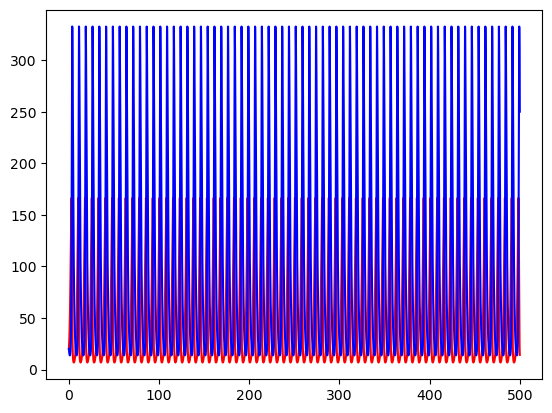

In [22]:
# Assume we are working in a Jupyter notebook so we don't need to import `run_cysolver` if it was defined in an earlier cell.
# from my_cython_code import run_cysolver

import numpy as np
initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)

result = run_reuse_cysolver(time_span, initial_conds)

print("Was Integration was successful?", result.success)
print(result.message)
print("Size of solution: ", result.size)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')
plt.show()